## Distributed Computing  Project - Task 2
## Tom Kovalcik
## CDs and Vinyl Amazon Reviews Dataset

### Imports

In [22]:
import pandas as pd
import pyspark
import os
import types
import datetime
import json
from pathlib import Path
from pyspark.sql import SparkSession
import json
import matplotlib.pyplot as plt

### Extract first 5000 lines from original dataset and save as separate file

In [13]:
cat_name = "CDs_and_Vinyl"
sample_size = 5000

input_path = Path(f"../../../{cat_name}.jsonl")
output_path = Path(f"../../data_samples/{cat_name}_SAMPLE.jsonl")


with input_path.open("r", encoding="utf-8") as file_obj:
    with output_path.open("w", encoding="utf-8") as out_file_obj:
        for i, line in enumerate(file_obj):
            if i < sample_size:
                out_file_obj.write(line)
            else:
                break
print(f"{sample_size} lines written to {output_path}")

5000 lines written to ../../data_samples/CDs_and_Vinyl_SAMPLE.jsonl


In [14]:
spark = (
    SparkSession.builder
    .appName("CDsAndVinylRDD")
    .master("local[*]")
    .config("spark.driver.bindAddress", "127.0.0.1")
    .getOrCreate()
)

sc = spark.sparkContext

path = str(output_path)

raw_rdd = sc.textFile(path)
records_rdd = raw_rdd.map(json.loads)

print("Number of records:", records_rdd.count())
print("First record:", records_rdd.first())

Number of records: 5000
First record: {'rating': 5.0, 'title': 'Five Stars', 'text': 'LOVE IT!', 'images': [], 'asin': 'B002MW50JA', 'parent_asin': 'B002MW50JA', 'user_id': 'AGKASBHYZPGTEPO6LWZPVJWB2BVA', 'timestamp': 1452650777000, 'helpful_vote': 0, 'verified_purchase': True}


In [18]:
from datetime import datetime

def to_year_month_rating(rec):
    """
    rec is a dict like:
    {
        'rating': 5.0,
        'timestamp': 1452650777000,
        ...
    }
    We map it to: ((year, month), (rating_sum, count))
    """
    ts = rec.get("timestamp")
    rating = rec.get("rating")

    if ts is None or rating is None:
        return None

    # timestamp is in milliseconds → convert to seconds
    dt = datetime.utcfromtimestamp(ts / 1000.0)
    year, month = dt.year, dt.month

    return ((year, month), (float(rating), 1))


# (1) Map to ((year, month), (rating, 1)) and drop bad rows
ym_rating_pairs = (
    records_rdd
    .map(to_year_month_rating)
    .filter(lambda x: x is not None)
)

# (2) Reduce to get (sum_ratings, count) per (year, month)
ym_agg = ym_rating_pairs.reduceByKey(
    lambda a, b: (a[0] + b[0], a[1] + b[1])
)

from datetime import datetime

def to_year_month_rating(rec):
    """
    rec is a dict like:
    {
        'rating': 5.0,
        'timestamp': 1452650777000,
        ...
    }
    We map it to: ((year, month), (rating_sum, count))
    """
    ts = rec.get("timestamp")
    rating = rec.get("rating")

    if ts is None or rating is None:
        return None

    # timestamp is in milliseconds → convert to seconds
    dt = datetime.utcfromtimestamp(ts / 1000.0)
    year, month = dt.year, dt.month

    return ((year, month), (float(rating), 1))


# 1) Map to ((year, month), (rating, 1)) and drop malformed rows
ym_rating_pairs = (
    records_rdd
    .map(to_year_month_rating)
    .filter(lambda x: x is not None)
)

# 2) Aggregate sum of ratings and count per (year, month)
#    ((year, month), (sum_ratings, count))
ym_agg = ym_rating_pairs.reduceByKey(
    lambda a, b: (a[0] + b[0], a[1] + b[1])
)

# 3) Compute (avg_rating, count) per (year, month)
#    ((year, month), (avg_rating, count))
ym_stats = ym_agg.mapValues(lambda s: (s[0] / s[1], s[1]))

# 4) Sort by (year, month) and collect
results = ym_stats.sortByKey().collect()

# 5) Pretty-print: year-month, avg rating, and count
for (year, month), (avg, cnt) in results:
    print(f"{year}-{month:02d}  avg_rating={avg:.3f}  count={cnt}")

1998-04  avg_rating=5.000  count=1
1998-07  avg_rating=4.000  count=1
1999-07  avg_rating=5.000  count=1
1999-08  avg_rating=5.000  count=2
1999-10  avg_rating=5.000  count=2
2000-03  avg_rating=5.000  count=1
2000-05  avg_rating=2.000  count=1
2000-06  avg_rating=5.000  count=2
2000-07  avg_rating=5.000  count=3
2000-08  avg_rating=5.000  count=2
2000-10  avg_rating=3.000  count=2
2000-12  avg_rating=5.000  count=3
2001-01  avg_rating=5.000  count=2
2001-02  avg_rating=5.000  count=1
2001-03  avg_rating=5.000  count=1
2001-04  avg_rating=4.667  count=3
2001-05  avg_rating=2.000  count=1
2001-06  avg_rating=4.667  count=3
2001-07  avg_rating=5.000  count=3
2001-08  avg_rating=5.000  count=1
2001-09  avg_rating=5.000  count=1
2001-10  avg_rating=5.000  count=13
2001-11  avg_rating=5.000  count=6
2001-12  avg_rating=5.000  count=2
2002-01  avg_rating=4.714  count=7
2002-02  avg_rating=5.000  count=2
2002-03  avg_rating=4.500  count=8
2002-04  avg_rating=5.000  count=8
2002-05  avg_rating

/var/folders/8q/48hstyms4z79cf6rxhybh5340000gn/T/ipykernel_18110/183620379.py:57: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
/var/folders/8q/48hstyms4z79cf6rxhybh5340000gn/T/ipykernel_18110/183620379.py:57: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).


In [24]:
import matplotlib.dates as mdates
from datetime import datetime

# Sort by (year, month) and collect to driver
results = ym_stats.sortByKey().collect()

# Build lists for plotting
dates = []
avg_ratings = []
counts = []

for (year, month), (avg, cnt) in results:
    # Use first day of month as the date
    dates.append(datetime(year, month, 1))
    avg_ratings.append(avg)
    counts.append(cnt)

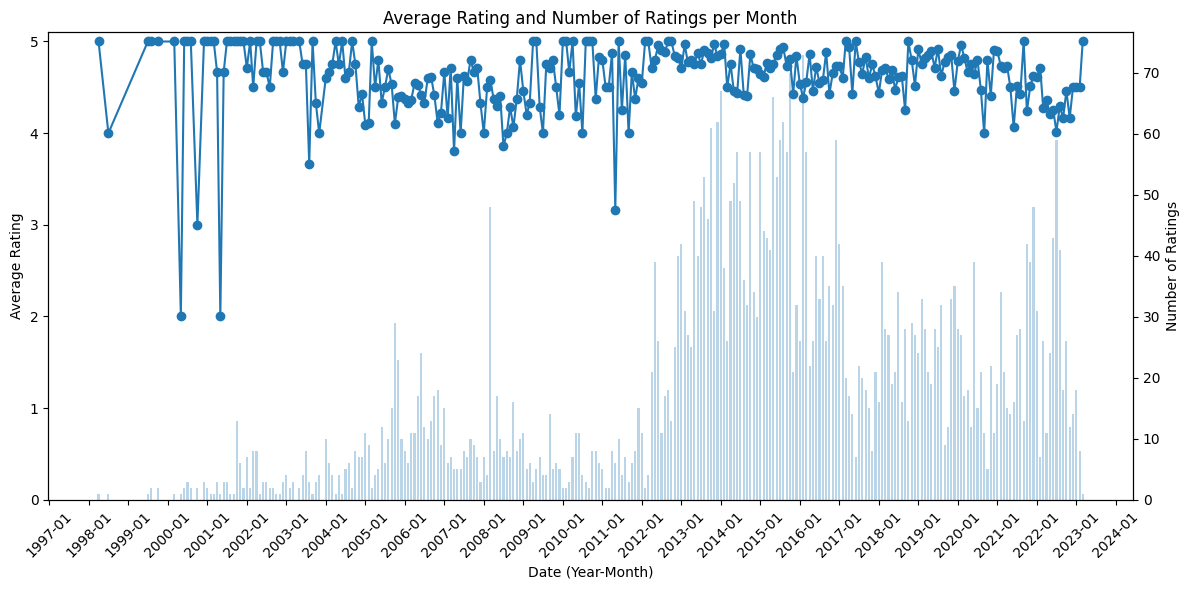

In [25]:
# %matplotlib inline  # Uncomment in Jupyter if needed

fig, ax1 = plt.subplots(figsize=(12, 6))

# Line plot for average rating
ax1.plot(dates, avg_ratings, marker="o")
ax1.set_xlabel("Date (Year-Month)")
ax1.set_ylabel("Average Rating", color="black")
ax1.tick_params(axis="y", labelcolor="black")
ax1.set_ylim(0, 5.1)  # ratings are typically 1–5

# Format x-axis as Year-Month
ax1.xaxis.set_major_locator(mdates.YearLocator())        # major ticks every year
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
plt.xticks(rotation=45)

# Second axis for counts (bar plot)
ax2 = ax1.twinx()
# width is in days (approx), so ~20 days gives a nice monthly bar width
ax2.bar(dates, counts, alpha=0.3, width=20)
ax2.set_ylabel("Number of Ratings", color="black")
ax2.tick_params(axis="y", labelcolor="black")

plt.title("Average Rating and Number of Ratings per Month")
plt.tight_layout()
plt.show()